# HAWC+ Data Analysis Techniques

In this jupyter cookbook, we will explore the [HAWC+](https://www.sofia.usra.edu/science/instruments/hawc) data cube and describe some of the basic analysis techniques involving imaging polarimetry data.

This cookbook follows the SOFIA press release of 30 Doradus observations: [SOFIA Reveals Never-Before-Seen Magnetic Field Details](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details).

The Level 4 reduced data from this program has been released immediately to the public and is available on the [SOFIA Data Cycle System (DCS)](https://dcs.sofia.usra.edu/).  This notebook will guide the reader through downloading the 30 Doradus data with a walkthrough of basic analysis techniques with `python`.

# Downloading HAWC+ Data

- If you do not yet have a DCS account, register for one at [https://dcs.sofia.usra.edu/userSupport/registration.jsp](https://dcs.sofia.usra.edu/userSupport/registration.jsp)
- Log into DCS: [https://dcs.sofia.usra.edu](https://dcs.sofia.usra.edu)
- Go to [Search Science Archive](https://dcs.sofia.usra.edu/dataRetrieval/SearchScienceArchiveInfoBasic.jsp)
- Fill in:
  - Instrument: `HAWC_PLUS` from drop-down menu
  - Processing State: `LEVEL_4` from drop-down menu
  - Target: 30Dor
  - Click the `SIMBAD Position` button
  - Change `Spatial Search Radius` to `600` arcsec
  - Click the `Submit` button
- After the results load, select the checkboxes next to each of the six rows of the table.
- Click `Get Selected Data in Current Page`
- Click `Request Data Bundle`
- After a few minutes, an email with a download link will be sent to the email address associated with your DCS account.
- For more information, consult the HAWC+ Data Handbook accessible at [https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources](https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources)

# SOFIA Data Organization
After downloading the SOFIA DCS bundle to your working directory you will want to unzip it, which will produce a directory structure like this:

```console
.
└── sofia_data
    ├── level4
    │   └── p5813
    │       └── F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits
    └── missions
        ├── 2018-07-05_HA_F481
        │   └── p5827
        │       └── F0481_HA_POL_7600012_HAWDHWPD_PMP_050-083.fits
        ├── 2018-07-07_HA_F483
        │   └── p5646
        │       └── F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits
        ├── 2018-07-11_HA_F484
        │   └── p5648
        │       └── F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits
        └── 2018-07-12_HA_F485
            └── p5658
                ├── g1
                │   └── F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
                └── g2
                    └── F0485_HA_POL_7600019_HAWEHWPE_PMP_055-075.fits
```

Note that each file represents observations with a different filter.  However, two observations were made with the same filter (HAWC C, $89\,\mathrm{\mu m}$).  These files, `F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits` and `F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits`, were combined into one: `level4->p5813->F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits`.

You can choose to keep the `fits` files nested, or copy them into one directory.

For the purpose of this basic analysis, though, let us dump all the files into one `sofia_data` directory:

```console
.
└── sofia_data
    ├── F0481_HA_POL_7600012_HAWDHWPD_PMP_050-083.fits
    ├── F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits
    ├── F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits
    ├── F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits
    ├── F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
    └── F0485_HA_POL_7600019_HAWEHWPE_PMP_055-075.fits
```

# Data Structure

For this analysis, we require the standard [numpy/scipy/matplotlib stack](https://scipy.org/install.html) as well the [astropy](http://docs.astropy.org/en/stable/) and [aplpy](https://aplpy.readthedocs.io/en/stable/index.html) modules.

With just a few lines of code, we can explore the HAWC+ `fits` data cubes and plot the images.

In [1]:
from astropy.io import fits

filename = 'sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits'
hawc = fits.open(filename)
hawc.info()

Filename: sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     572   (94, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (94, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (94, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (94, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (94, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (94, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (94, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (94, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (94, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        18   (94, 114)   float

We can see above the data structure of the multi-extension `fits` files.  Each file contains 19 extensions which encapsulates all of the Stokes parameters in a single package.

## Stokes I
Stokes $I$---the zeroth extension in the `fits` file---represents the total intensity of the image, where $I^2 = Q^2 + U^2$.


Let us go ahead and plot this extension:

/home/gordon/miniconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


<IPython.core.display.Javascript object>


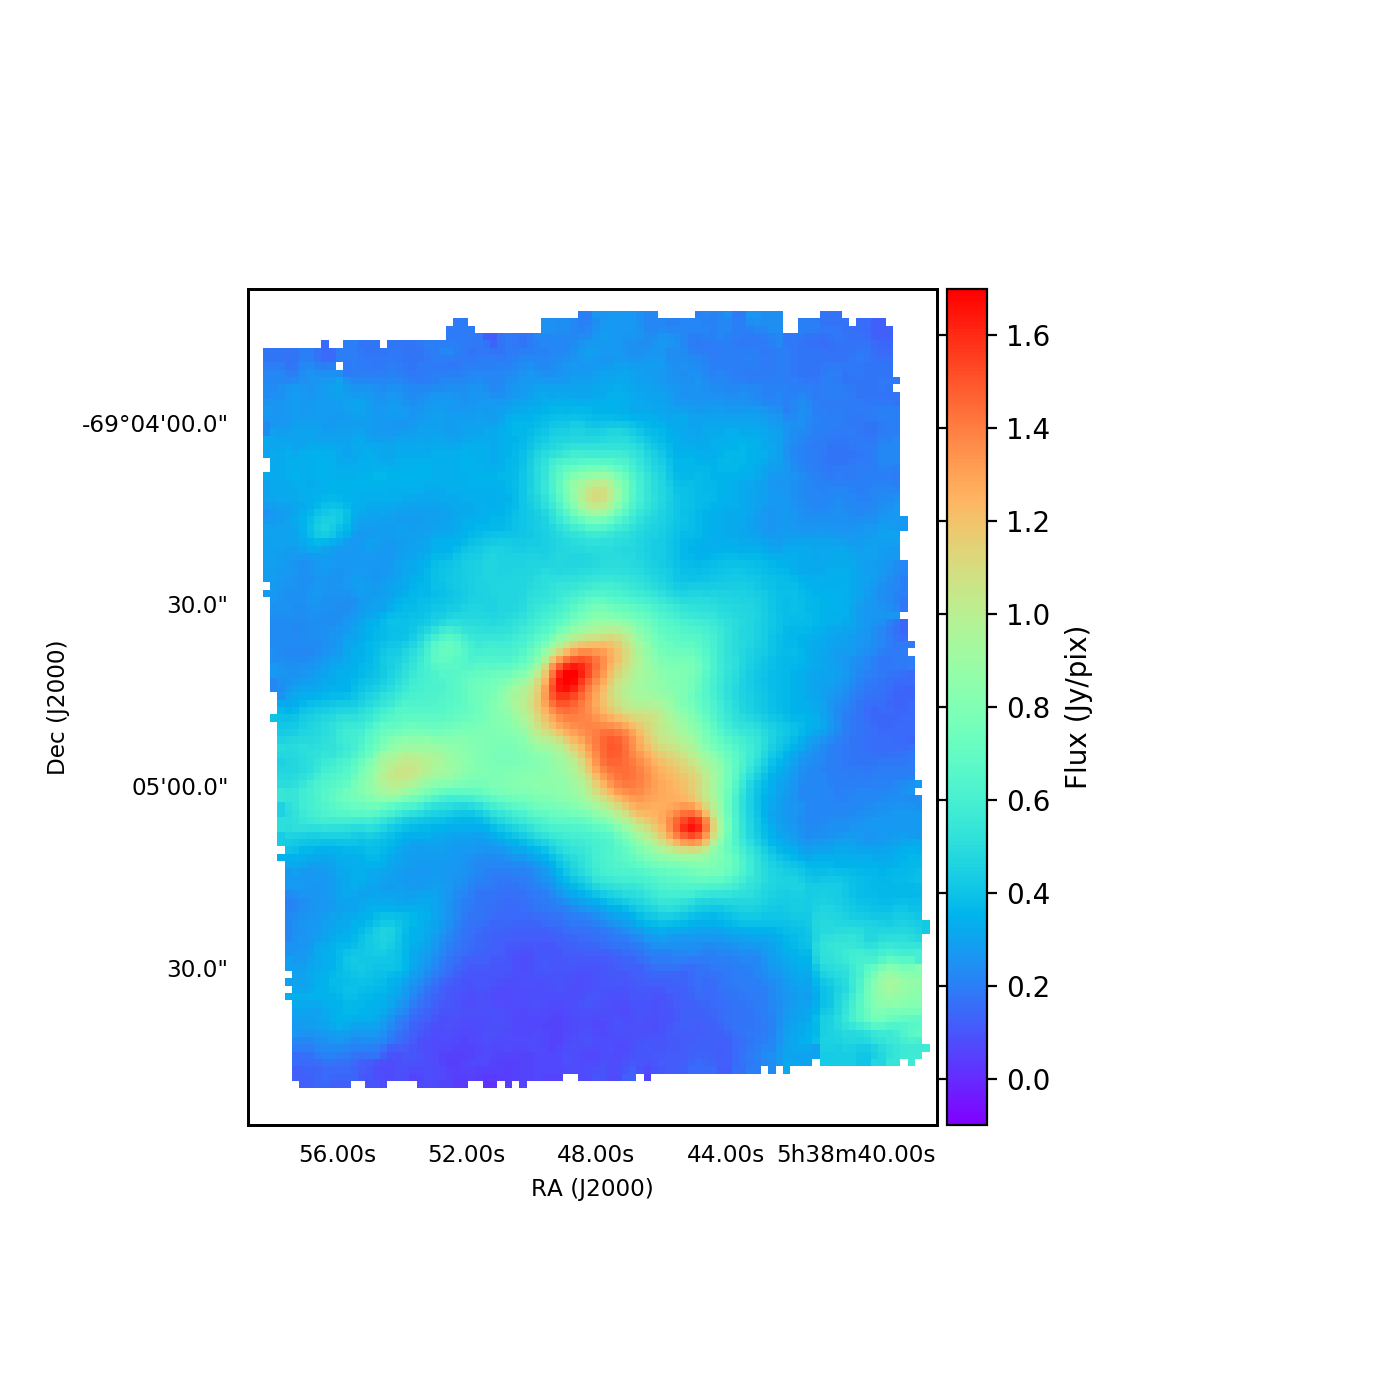

INFO: Auto-setting vmin to -9.832e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.698e+00 [aplpy.core]


/home/gordon/miniconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
# ^jupyter magic for inline plots
from aplpy import FITSFigure

# set colormap for all plots
cmap = 'rainbow'

stokes_i = hawc['STOKES I']               # or hawc[0]. Note the extension is from the hawc.info() table above

fig = plt.figure(figsize=(7,7))

axs = FITSFigure(stokes_i, figure=fig)    # load HDU into aplpy figure
axs.show_colorscale(cmap=cmap)            # display the data with WCS projection and chosen colormap

# FORMATTING
axs.set_tick_labels_font(size='small')
axs.set_axis_labels_font(size='small')

# Add colorbar
axs.add_colorbar()
axs.colorbar.set_axis_label_text('Flux (Jy/pix)')

## Stokes Q and U
Similarly, we can plot the Stokes Q and Stokes U images:

<IPython.core.display.Javascript object>


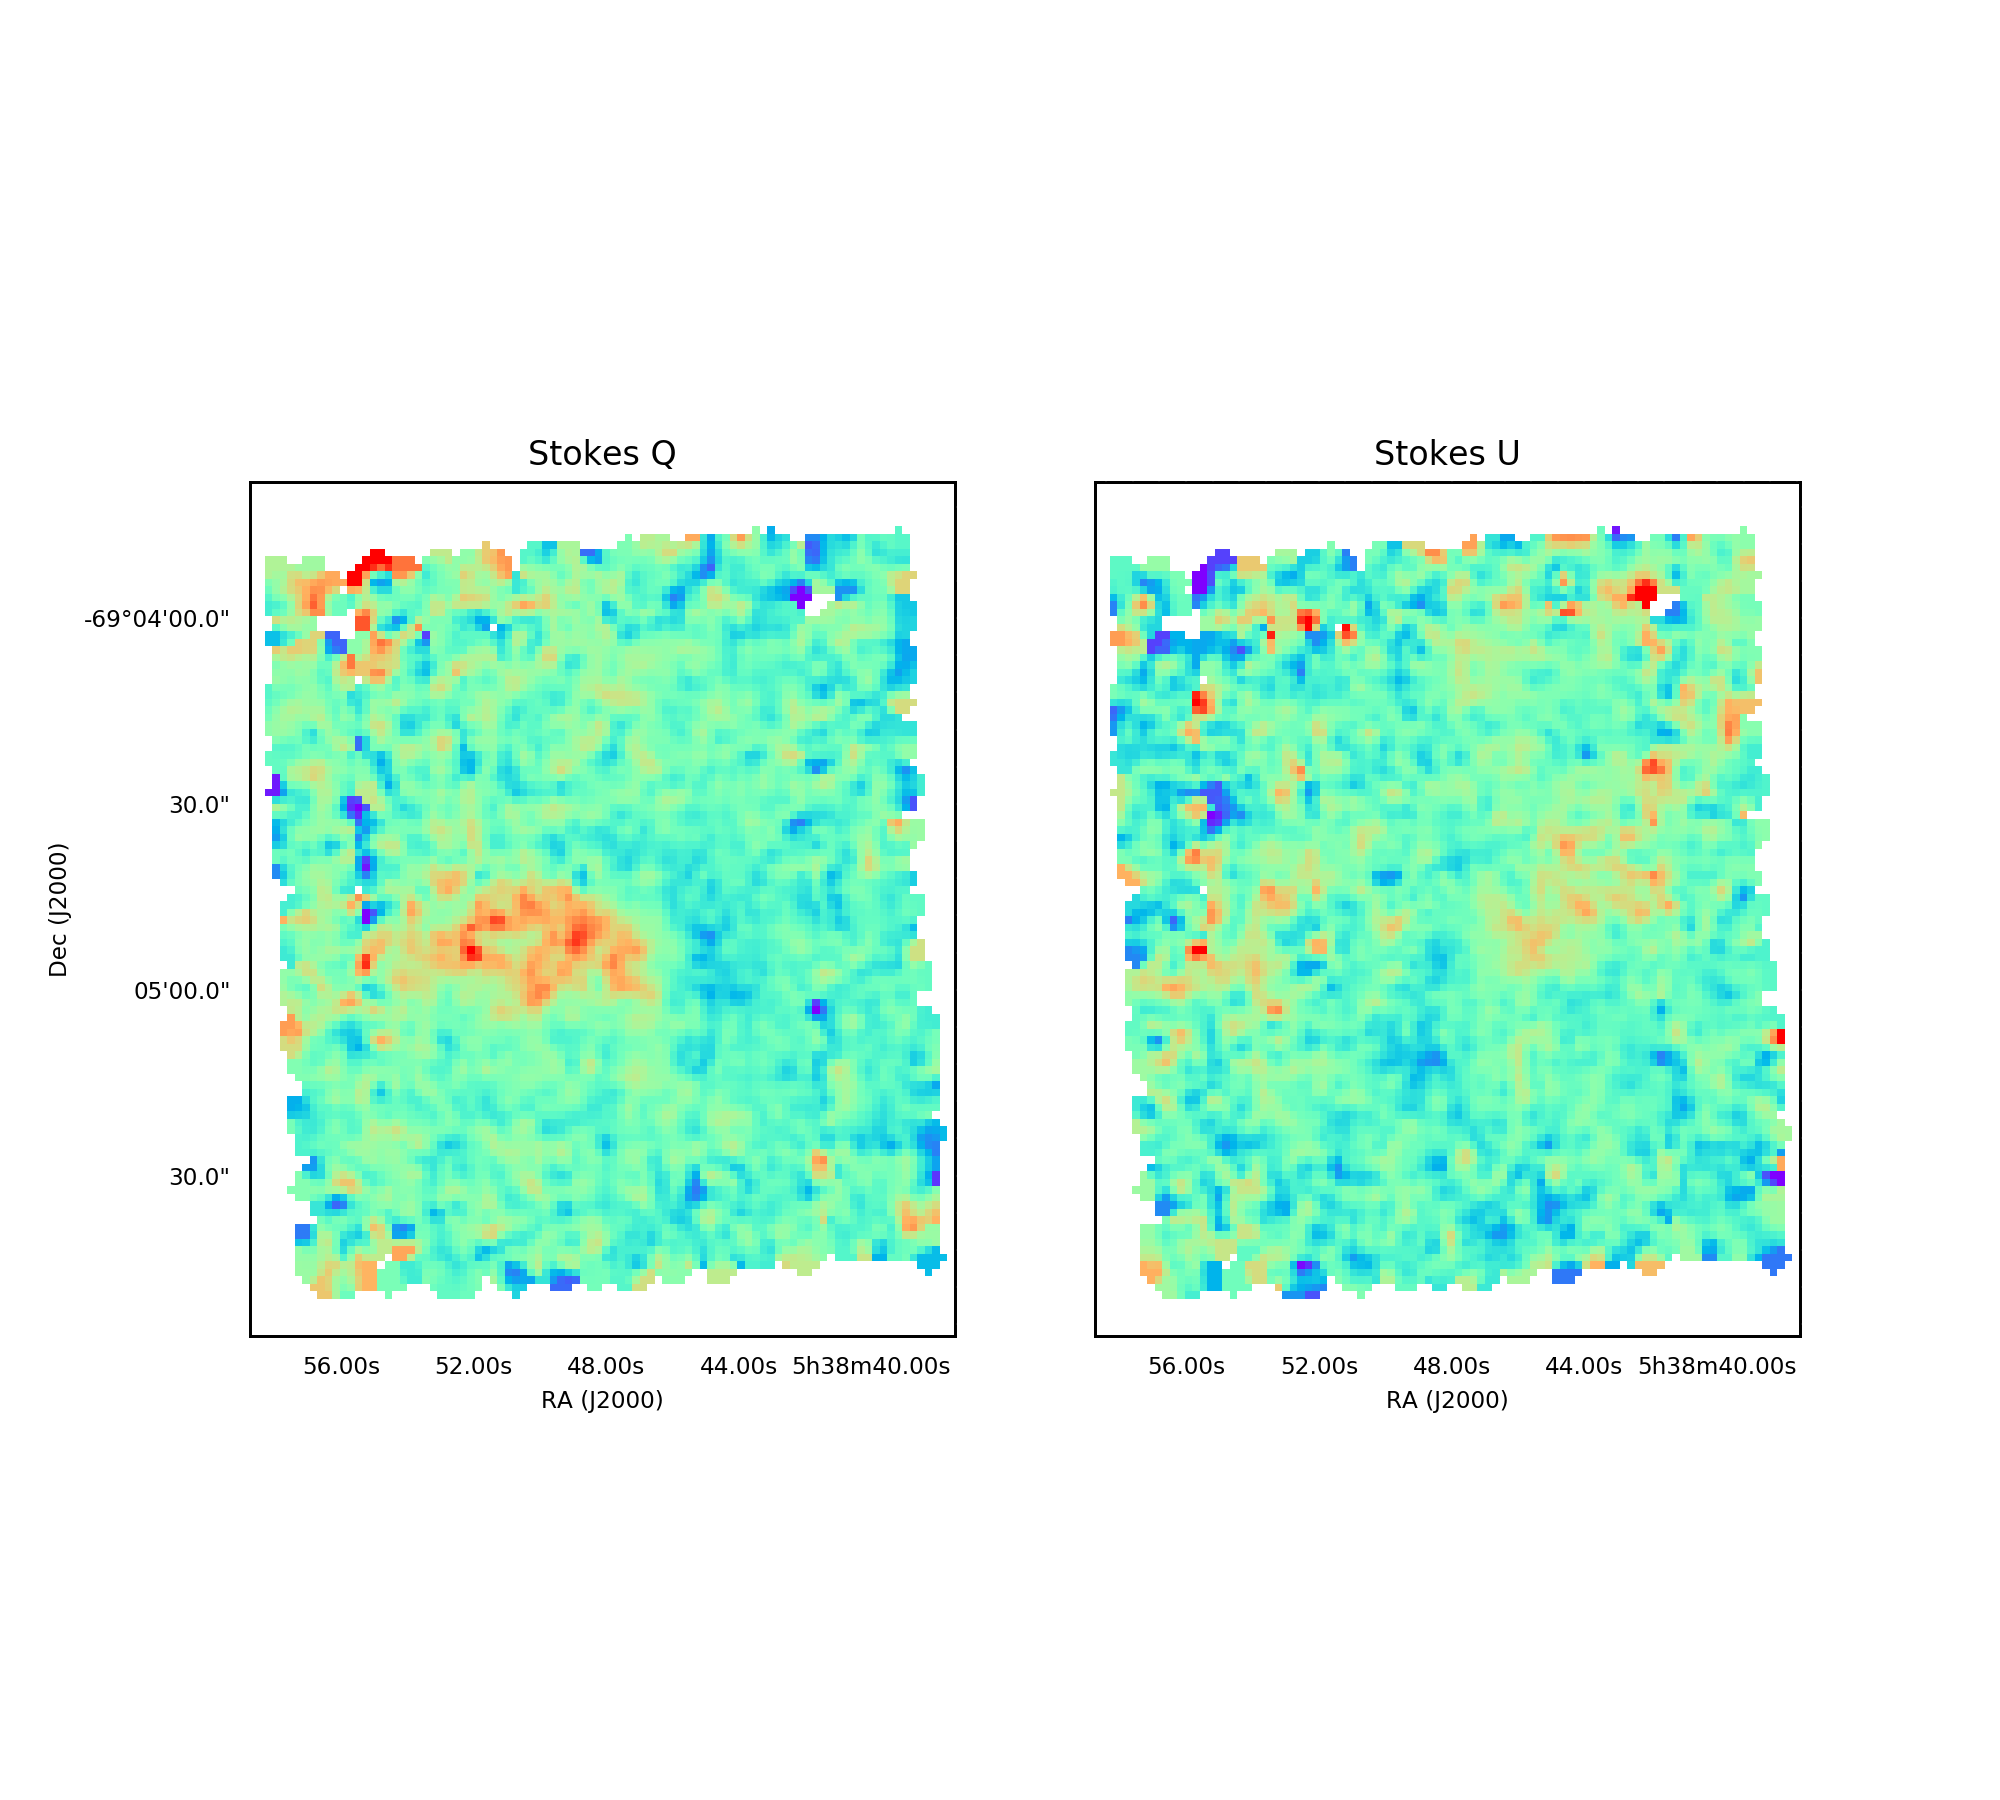

INFO: Auto-setting vmin to -6.959e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.873e-02 [aplpy.core]


/home/gordon/miniconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmin to -6.281e-02 [aplpy.core]
INFO: Auto-setting vmax to  7.749e-02 [aplpy.core]


In [3]:
stokes_q = hawc['STOKES Q']
stokes_u = hawc['STOKES U']

axq = FITSFigure(stokes_q, subplot=(1,2,1))  # generate FITSFigure as subplot to have two axes together
axq.show_colorscale(cmap=cmap)               # show Q


axu = FITSFigure(stokes_u, subplot=(1,2,2),
                 figure=plt.gcf(), sharex=axq,sharey=axq)  # shared so the axes zoom together
axu.show_colorscale(cmap=cmap)               # show U

# FORMATTING
axq.set_title('Stokes Q')
axu.set_title('Stokes U')
axu.axis_labels.hide_y()                     # hide axis ticklabels for U figure
axu.tick_labels.hide_y()
axq.set_tick_labels_font(size='small')
axq.set_axis_labels_font(size='small')
axu.set_tick_labels_font(size='small')
axu.set_axis_labels_font(size='small')

We can additionally plot the associated error maps for each extension.

<IPython.core.display.Javascript object>


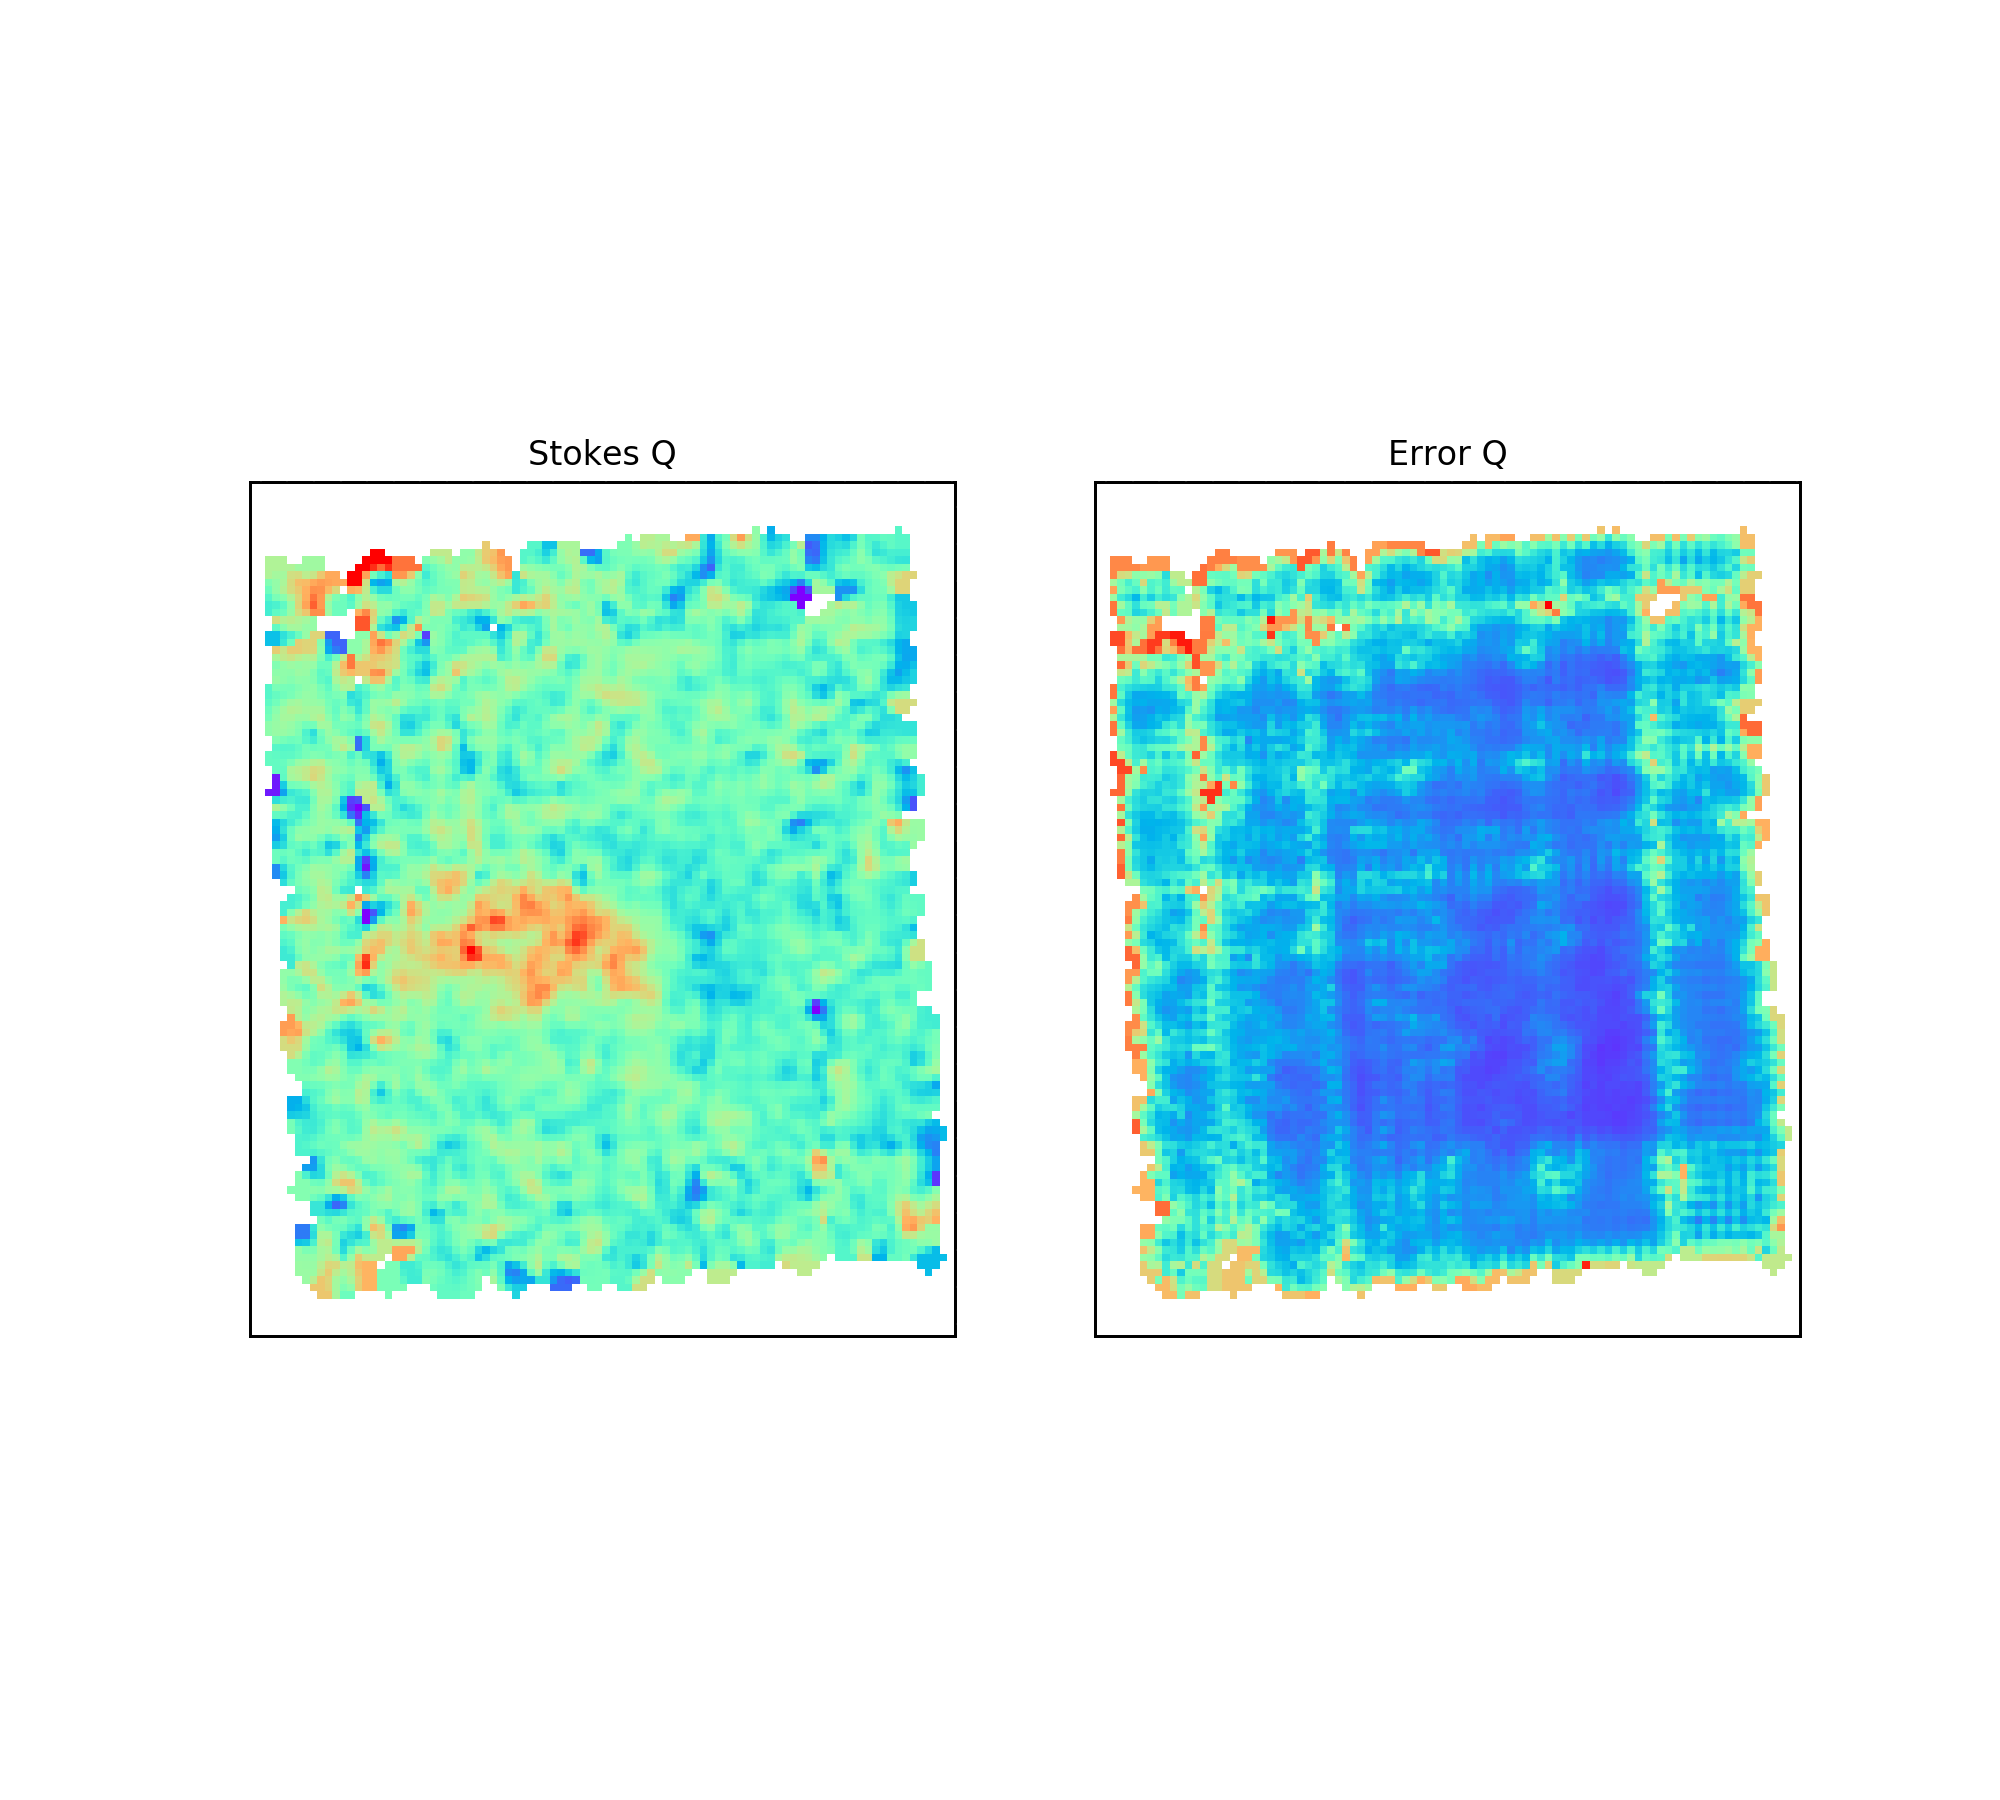

INFO: Auto-setting vmin to -6.959e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.873e-02 [aplpy.core]


/home/gordon/miniconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmin to  3.739e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.337e-02 [aplpy.core]


In [4]:
stokes_q = hawc['STOKES Q']
error_q = hawc['ERROR Q']

axq = FITSFigure(stokes_q, subplot=(1,2,1))  # generate FITSFigure as subplot to have two axes together
axq.show_colorscale(cmap=cmap)               # show Q


axe = FITSFigure(error_q, subplot=(1,2,2),
                 figure=plt.gcf(), sharex=axq,sharey=axq)  # shared so the axes zoom together
axe.show_colorscale(cmap=cmap)               # show error

# FORMATTING
axq.set_title('Stokes Q')
axe.set_title('Error Q')
axq.axis_labels.hide()                       # hide axis/tick labels
axe.axis_labels.hide()
axq.tick_labels.hide()
axe.tick_labels.hide()

## Polarized Intensity $I_p$
Level 4 HAWC+ additionally provides extensions with the polarization percentage ($p$), angle ($\theta$), and their associated errors ($\sigma$).

Percent polarization ($p$) and error ($\sigma_p$) are calculated as:

$p = 100\sqrt{\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2}$

$\sigma_p = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}$ .

Note that $p$ here represents the **percent** polarization as opposed to the more typical convention for $p$ as the **fractional** polarization.

Maps of these data are found in extensions 7 (PERCENT POL) and 9 (ERROR PERCENT POL).

Polarized intensity, $I_p$, can then be calculated as $I_p = \frac{I\times p}{100}$, which is included in extension 13 (POL FLUX).

Also included is the debiased polarization percentage ($p^\prime$) calculated as:

$p^\prime=\sqrt{p^2-\sigma_p^2}$, found in extension 8 (DEBIASED PERCENT POL).

We similarly define the debiased polarized intensity as $I_{p^\prime} = \frac{I\times p^\prime}{100}$, which is included in extension 15 (DEBIASED POL FLUX).

<IPython.core.display.Javascript object>


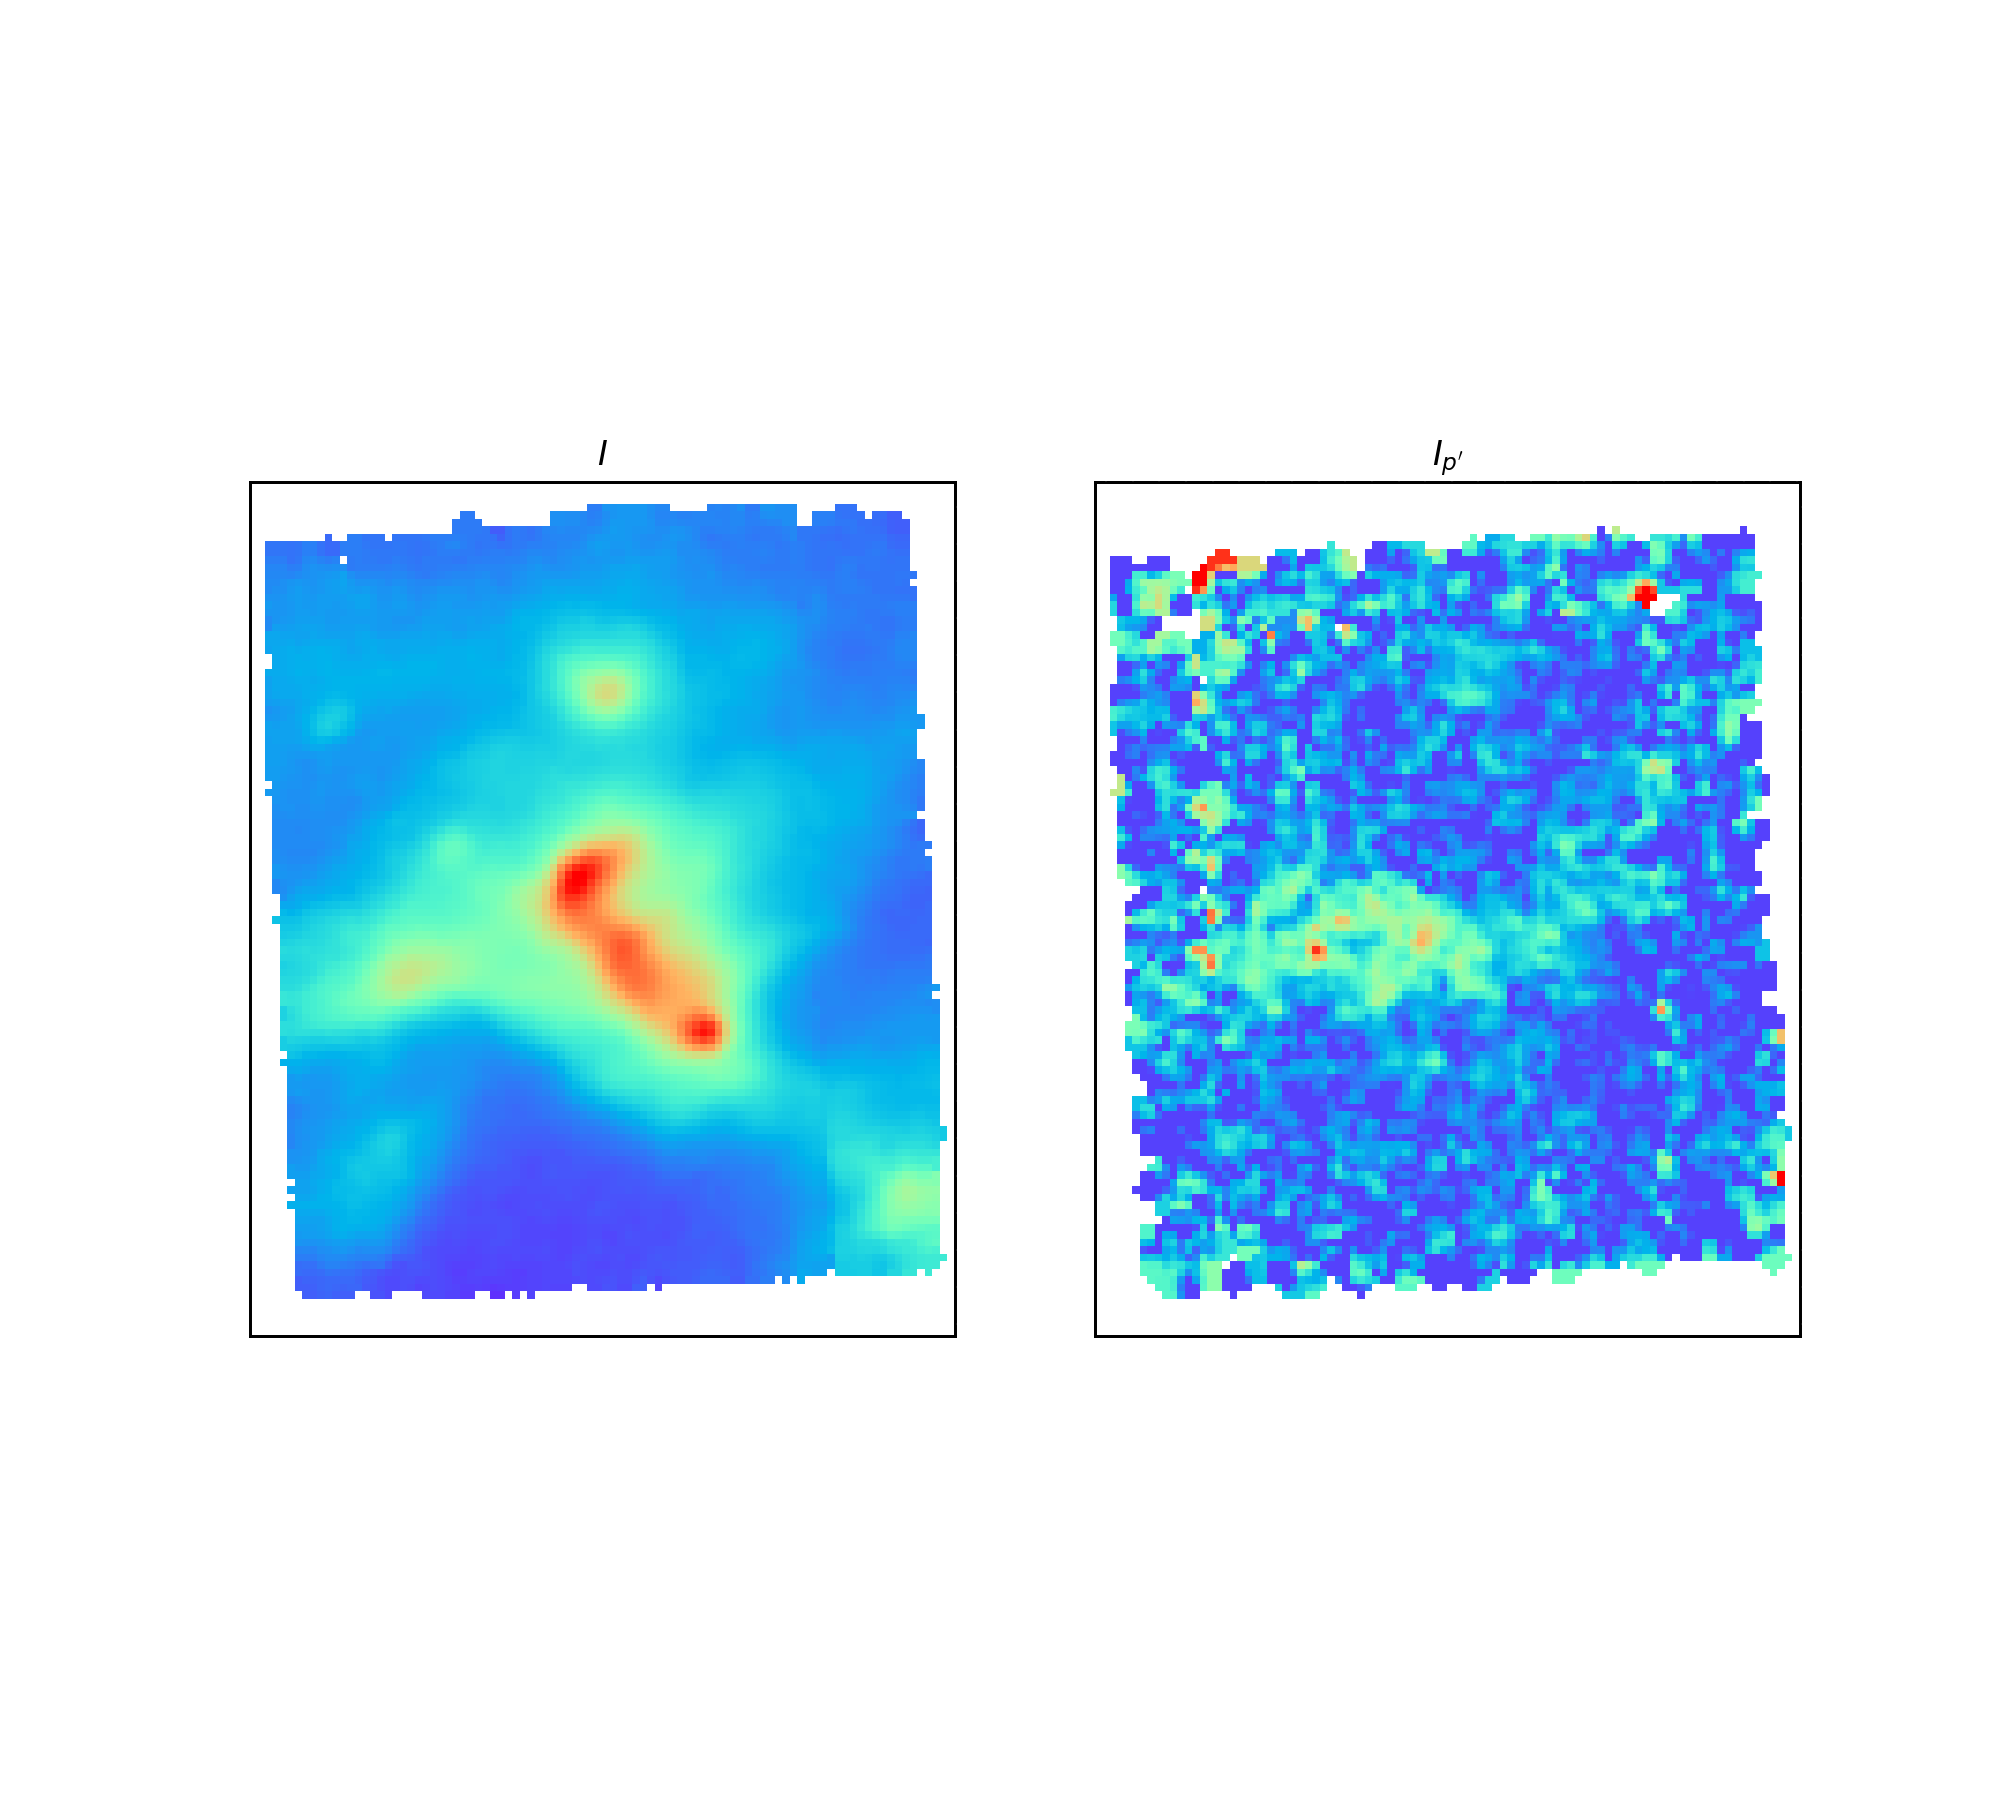

INFO: Auto-setting vmin to -9.832e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.698e+00 [aplpy.core]


/home/gordon/miniconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmin to -9.530e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.058e-01 [aplpy.core]


In [5]:
stokes_ip = hawc['DEBIASED POL FLUX']

axi = FITSFigure(stokes_i, subplot=(1,2,1))
axi.show_colorscale(cmap=cmap)               # show I


axp = FITSFigure(stokes_ip, subplot=(1,2,2),
                 figure=plt.gcf(), sharex=axq,sharey=axq)
axp.show_colorscale(cmap=cmap)               # show Ip

# FORMATTING
axi.set_title(r'$I$')
axp.set_title(r'$I_{p^\prime}$')
axi.axis_labels.hide()                       # hide axis/tick labels
axp.axis_labels.hide()
axi.tick_labels.hide()
axp.tick_labels.hide()

# Plotting Polarization Vectors

From the $Q$ and $U$ maps, the polarization angle $\theta$ is calculated in the standard way:

$\theta = \frac{90}{\pi}\,\mathrm{tan^{-1}}\left(\frac{U}{Q}\right)$

with associated error:

$\sigma_\theta = \frac{90}{\pi\left(Q^2+U^2\right)}\sqrt{\left(Q\sigma_Q\right)^2+\left(U\sigma_U\right)^2-2QU\sigma_{QU}}$

The angle map is stored in extension 10 (POL ANGLE), with its error in extension 12 (ERROR POL ANGLE).  

However, these angles are relative to detector coordinates.  The angle we are more interested in is the angle on the sky.  As part of the HAWC+ reduction pipeline, $\theta$ is corrected for the vertical position angle of the instrument on the sky, the angle of the HWP plate, as well as an offset angle that is calibrated to each filter configuration.  This correction angle is applied to $\theta\rightarrow\theta^\prime$ and is saved to extension 11 (ROTATED POL ANGLE).  This also affects the Stokes $Q$ and $U$ parameters, and so this factor has already been rolled into the STOKES Q and STOKES U extensions (and their corresponding error maps) in the HAWC+ data cube.

We can now use the $p^\prime$ and $\theta^\prime$ maps to plot the polarization vectors.

We perform the following steps:
1.  use the Stokes $I$ image as the background for the vector plot
2.  perform a quality cut on Stokes $I/\sigma_I > 100$ to make a mask
3.  mask out low S/N vectors
4.  plot remaining polarization vectors
5.  add contours to better visualize changes in flux across the map

<IPython.core.display.Javascript object>


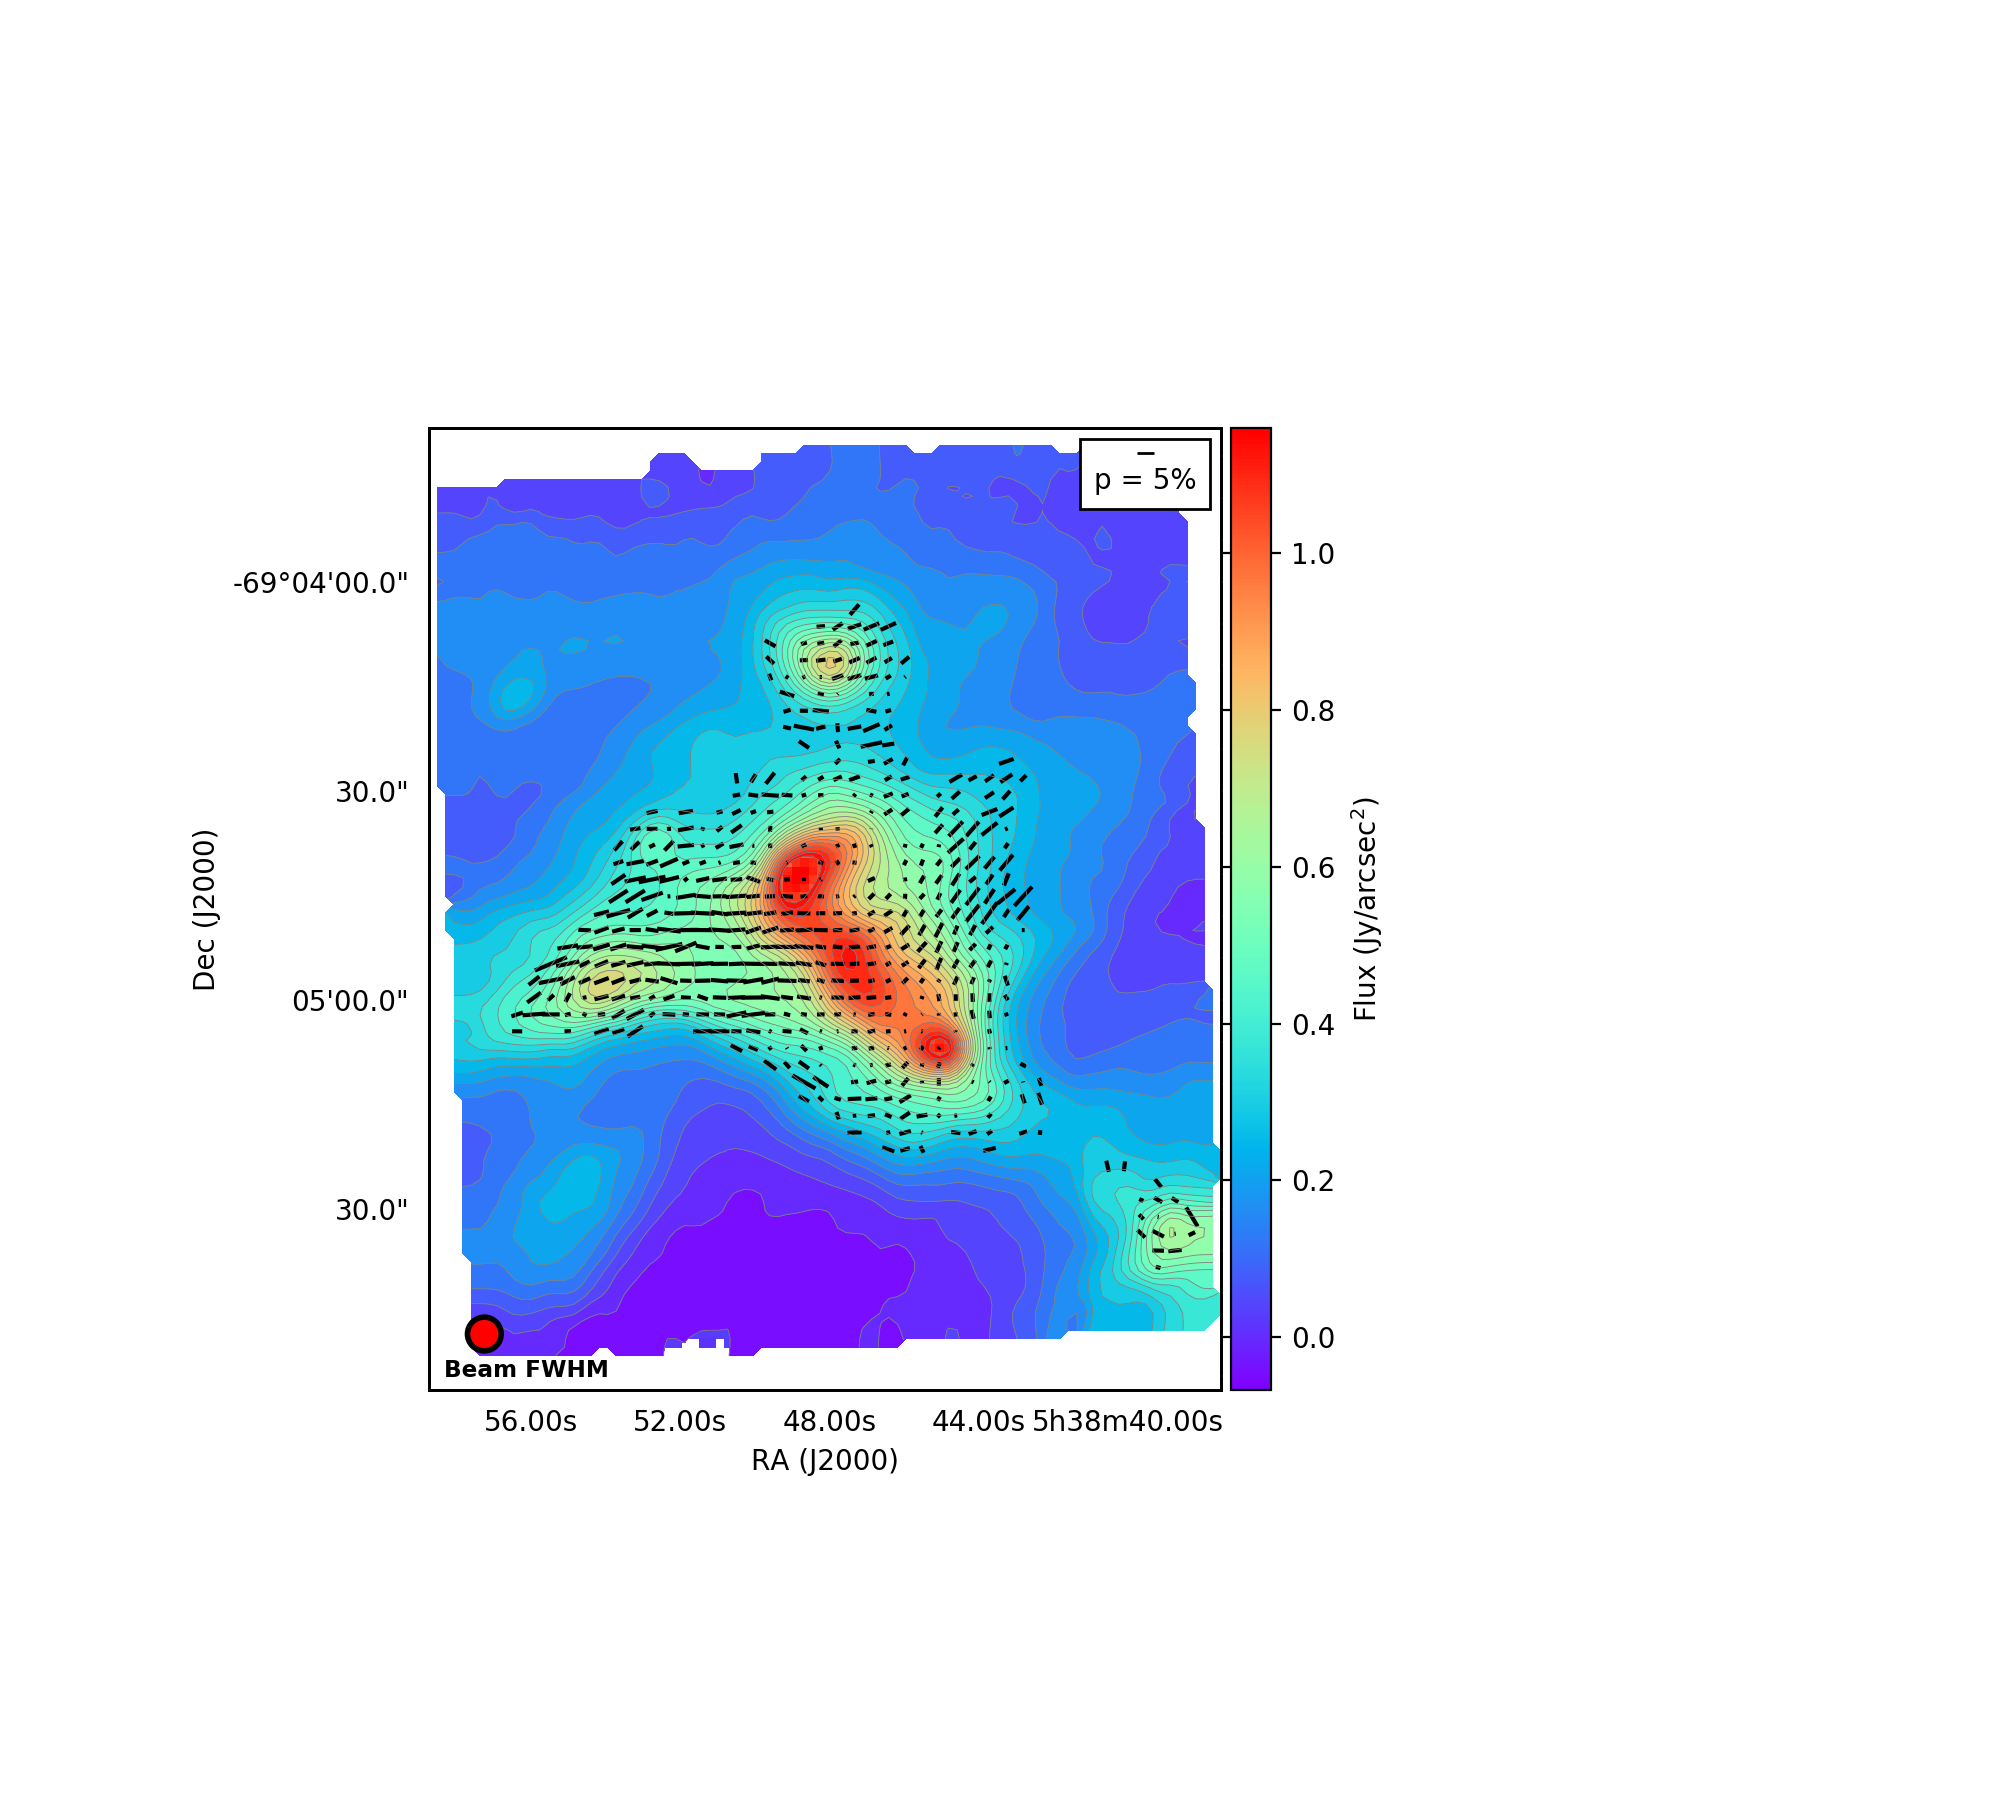

/home/gordon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


INFO: Auto-setting vmin to -6.715e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.160e+00 [aplpy.core]


/home/gordon/miniconda3/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


In [6]:
import numpy as np
from astropy.stats import sigma_clip

p = hawc['DEBIASED PERCENT POL']    # %
theta = hawc['ROTATED POL ANGLE']   # deg
stokes_i = hawc['STOKES I']         # I
error_i = hawc['ERROR I']          # error I

# 1. plot Stokes I
#  convert from Jy/pix to Jy/sq. arcsec
pxscale = stokes_i.header['CDELT2']*3600  # map scale in arcsec/pix
stokes_i.data /= pxscale**2
error_i.data /= pxscale**2

fig = FITSFigure(stokes_i)

# 2. perform S/N cut on I/\sigma_I
err_lim = 100
mask = np.where(stokes_i.data/error_i.data < err_lim)

# 3. mask out low S/N vectors by setting masked indices to NaN
p.data[mask] = np.nan

# 4. plot vectors
scalevec = 0.4  # 1pix = scalevec * 1% pol          # scale vectors to make it easier to see 
fig.show_vectors(p, theta, scale=scalevec, step=2)  # step size = display every 'step' vectors
                                                    #   step size of 2 is effectively Nyquist sampling
                                                    #   --close to the beam size

# 5. plot contours
ncontours = 30
fig.show_contour(stokes_i, cmap=cmap, levels=ncontours,
                 filled=True, smooth=1, kernel='box')
fig.show_contour(stokes_i, colors='gray', levels=ncontours,
                 smooth=1, kernel='box', linewidths=0.3)

# Show image
fig.show_colorscale(cmap=cmap)

# Add colorbar
fig.add_colorbar()
fig.colorbar.set_axis_label_text('Flux (Jy/arcsec$^2$)')

# Add beam indicator
fig.add_beam(facecolor='red', edgecolor='black',
             linewidth=2, pad=1, corner='bottom left')
fig.add_label(0.02, 0.02, 'Beam FWHM',
              horizontalalignment='left', weight='bold',
              relative=True, size='small')

# Add vector scale
#   polarization vectors are displayed such that 'scalevec' * 1% pol is 1 pix long
#   must translate pixel size to angular degrees since the 'add_scalebar' function assumes a physical scale
vectscale = scalevec * pxscale/3600
fig.add_scalebar(5 * vectscale, "p = 5%",corner='top right',frame=True)

# Overlaying ALMA Data

In [7]:
from astroquery.alma import Alma
from os.path import basename

criteria = {
    'band_list': 3,
    'spatial_resolution': '<5'
}

#results = Alma.query_object('30Dor', payload=criteria)

#radio_data = Alma.retrieve_data_from_uid(results[0]['Member ous id'])
#radio_images = Alma.get_files_from_tarballs(radio_data)

# Get only the HCO image file
#radio_image = [filename for filename in radio_images if \
#               basename(filename) == '30DorBand3.ms.HCOp.image.fits'][0]

In [8]:
#fig = FITSFigure(radio_image)
#fig.show_colorscale(cmap=cmap)